# Experimental Evaluation Figures
This notebook aggregates all benchmarking workflows to reproduce the figures and plots for the experimental evaluation section of [Littau_QuASAr.pdf](../../Littau_QuASAr.pdf).

## Imported from `00_environment_setup.ipynb`

# Environment Setup

This notebook captures system information for benchmarking and saves it to `environment.json`.


In [ ]:
import json, platform, subprocess, psutil, numpy as np, os
from pathlib import Path


def get_cpu_model():
    system = platform.system()
    if system == "Linux":
        try:
            with open("/proc/cpuinfo") as f:
                for line in f:
                    if "model name" in line:
                        return line.split(":", 1)[1].strip()
        except Exception:
            pass
    elif system == "Darwin":
        try:
            return subprocess.check_output(
                ["sysctl", "-n", "machdep.cpu.brand_string"], text=True
            ).strip()
        except Exception:
            pass
    return platform.processor()

info = {}
info["cpu_model"] = get_cpu_model()
info["cpu_count"] = psutil.cpu_count()
info["ram_gb"] = round(psutil.virtual_memory().total / 1024**3, 2)
info["os"] = platform.platform()
info["python_version"] = platform.python_version()
info["blas_libraries"] = getattr(np.__config__, "blas_opt_info", {}).get("libraries", [])
info["lapack_libraries"] = getattr(np.__config__, "lapack_opt_info", {}).get("libraries", [])
import stim, mqt.ddsim, mqt.core
info["stim_version"] = getattr(stim, "__version__", None)
info["mqt_dd_version"] = getattr(mqt.ddsim, "__version__", None)
info["mqt_core_version"] = getattr(mqt.core, "__version__", None)
try:
    import pybind11
    info["pybind11_version"] = pybind11.__version__
except Exception:
    info["pybind11_version"] = None
info["quasar_commit"] = subprocess.check_output(["git","rev-parse","HEAD"]).decode().strip()

def run_cmd(cmd):
    try:
        return subprocess.check_output(cmd, text=True).splitlines()[0]
    except Exception:
        return None
info["compiler"] = run_cmd(["cc","--version"]) or run_cmd(["gcc","--version"])
info["cmake_version"] = run_cmd(["cmake","--version"])
info["QUASAR_QUICK_MAX_QUBITS"] = os.getenv("QUASAR_QUICK_MAX_QUBITS")
info["QUASAR_QUICK_MAX_GATES"] = os.getenv("QUASAR_QUICK_MAX_GATES")
info["QUASAR_QUICK_MAX_DEPTH"] = os.getenv("QUASAR_QUICK_MAX_DEPTH")
info["QUASAR_MPS_TARGET_FIDELITY"] = os.getenv("QUASAR_MPS_TARGET_FIDELITY")
Path("environment.json").write_text(json.dumps(info, indent=2, default=str))
info

Environment information saved to `environment.json`.


## Benchmark Circuits

The table below lists benchmark circuits used in QuASAr.

In [2]:
from benchmarks.circuits import (
    clifford_ec_circuit,
    ripple_add_circuit,
    vqe_chain_circuit,
    random_hybrid_circuit,
    recur_subroutine_circuit,
)
import inspect
from pathlib import Path
from IPython.display import Markdown


def src_link(func):
    file = Path(inspect.getsourcefile(func)).resolve()
    try:
        file = file.relative_to(Path.cwd())
    except ValueError:
        file = file.relative_to(Path.cwd().parent)
    line = inspect.getsourcelines(func)[1]
    return f"[generator]({file}#L{line})"

circuits = [
    ("Clifford-EC", clifford_ec_circuit, "3-qubit bit-flip error correction"),
    ("Ripple-Add", ripple_add_circuit, "Ripple-carry adder for two 4-bit registers"),
    ("VQE-Chain", vqe_chain_circuit, "VQE ansatz with linear entanglement chain"),
    ("Random-Hybrid", random_hybrid_circuit, "Random mix of Clifford and T gates"),
    ("Recur-Subroutine", recur_subroutine_circuit, "Circuit with repeated subroutine layers"),
]

rows = ["| Circuit | Qubits | Gates | Description | Source |", "|---|---|---|---|---|"]
for name, fn, desc in circuits:
    circ = fn()
    rows.append(f"| {name} | {circ.num_qubits} | {circ.num_gates} | {desc} | {src_link(fn)} |")
Markdown("\n".join(rows))


SyntaxError: unterminated string literal (detected at line 30) (744733715.py, line 30)

In [3]:

# Record parameters and results
import json, pathlib
try:
    import ipynbname
    nb_name = ipynbname.path().stem
except Exception:  # pragma: no cover
    nb_name = 'notebook'

# Collect simple parameters from globals
_params = {
    k: v for k, v in globals().items()
    if not k.startswith('_') and isinstance(v, (int, float, str, bool, list, dict, tuple))
}
pathlib.Path('../results').mkdir(exist_ok=True)
with open(f"../results/{nb_name}_params.json", 'w') as f:
    json.dump(_params, f, indent=2, default=str)
if 'results' in globals():
    try:
        with open(f"../results/{nb_name}_results.json", 'w') as f:
            json.dump(results, f, indent=2, default=str)
    except TypeError:
        pass
print(json.dumps(_params, indent=2, default=str))


{
  "In": [
    "",
    "import json, platform, subprocess, psutil, numpy as np, os\nfrom pathlib import Path\n\ninfo = {}\ninfo['cpu_model'] = next((l.split(':',1)[1].strip() for l in open('/proc/cpuinfo') if 'model name' in l), platform.processor())\ninfo['cpu_count'] = psutil.cpu_count()\ninfo['ram_gb'] = round(psutil.virtual_memory().total / 1024**3, 2)\ninfo['os'] = platform.platform()\ninfo['python_version'] = platform.python_version()\ninfo['blas_libraries'] = getattr(np.__config__, 'blas_opt_info', {}).get('libraries', [])\ninfo['lapack_libraries'] = getattr(np.__config__, 'lapack_opt_info', {}).get('libraries', [])\nimport stim, mqt.ddsim, mqt.core\ninfo['stim_version'] = getattr(stim, '__version__', None)\ninfo['mqt_dd_version'] = getattr(mqt.ddsim, '__version__', None)\ninfo['mqt_core_version'] = getattr(mqt.core, '__version__', None)\ntry:\n    import pybind11\n    info['pybind11_version'] = pybind11.__version__\nexcept Exception:\n    info['pybind11_version'] = None\ninfo[

## Imported from `01_microbenchmarks.ipynb`

# Microbenchmarks

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from benchmarks.runner import BenchmarkRunner

In [2]:
chis = [8, 16, 32, 64, 128, 256, 512]
reps = 5
svd_results = []
for chi in chis:
    runner = BenchmarkRunner()
    times = []
    mems = []
    for _ in range(reps):
        mat = np.random.randn(chi, chi)
        rec = runner.run_multiple(mat, lambda m: np.linalg.svd(m, full_matrices=False), repetitions=3)
        times.append(rec['run_time_mean'])
        mems.append(rec['run_peak_memory_mean'])
    svd_results.append({
        'chi': chi,
        'mean_time': np.mean(times),
        'std_time': np.std(times),
        'mean_mem': np.mean(mems),
        'std_mem': np.std(mems)
    })
svd_df = pd.DataFrame(svd_results)
svd_df

,chi,mean_time,std_time,mean_mem,std_mem
0,8,0.000167,0.000119,2849.0,236.989451
1,16,0.000128,0.000010,5816.0,0.000000
2,32,0.000280,0.000063,18232.0,0.000000
3,64,0.001212,0.000639,67640.0,0.000000
4,128,0.004914,0.001106,264760.0,0.000000


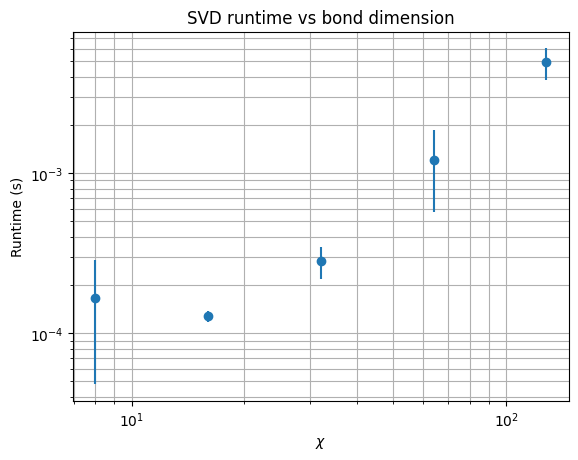

In [3]:
plt.figure()
plt.errorbar(svd_df['chi'], svd_df['mean_time'], yerr=svd_df['std_time'], fmt='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\chi$')
plt.ylabel('Runtime (s)')
plt.title('SVD runtime vs bond dimension')
plt.grid(True, which='both')
plt.show()


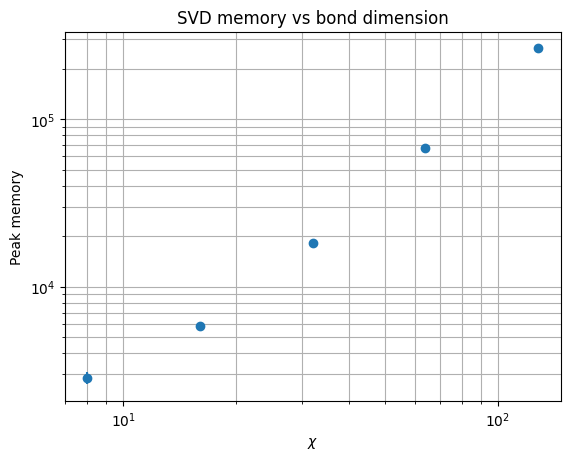

In [4]:
plt.figure()
plt.errorbar(svd_df['chi'], svd_df['mean_mem'], yerr=svd_df['std_mem'], fmt='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\chi$')
plt.ylabel('Peak memory')
plt.title('SVD memory vs bond dimension')
plt.grid(True, which='both')
plt.show()


In [5]:
frontiers = [10, 50, 200, 1000, 5000, 20000]
reps = 5
dd_results = []
for r in frontiers:
    runner = BenchmarkRunner()
    times = []
    mems = []
    for _ in range(reps):
        data = np.random.rand(r)
        rec = runner.run_multiple(data, lambda x: np.sort(x), repetitions=3)
        times.append(rec['run_time_mean'])
        mems.append(rec['run_peak_memory_mean'])
    dd_results.append({
        'frontier': r,
        'mean_time': np.mean(times),
        'std_time': np.std(times),
        'mean_mem': np.mean(mems),
        'std_mem': np.std(mems)
    })
dd_df = pd.DataFrame(dd_results)
dd_df

,frontier,mean_time,std_time,mean_mem,std_mem
0,10,0.000067,0.000098,2964.533333,185.066667
1,50,0.000012,0.000002,3192.000000,0.000000
2,200,0.000012,0.000002,4392.000000,0.000000
3,1000,0.000016,0.000002,10792.000000,0.000000


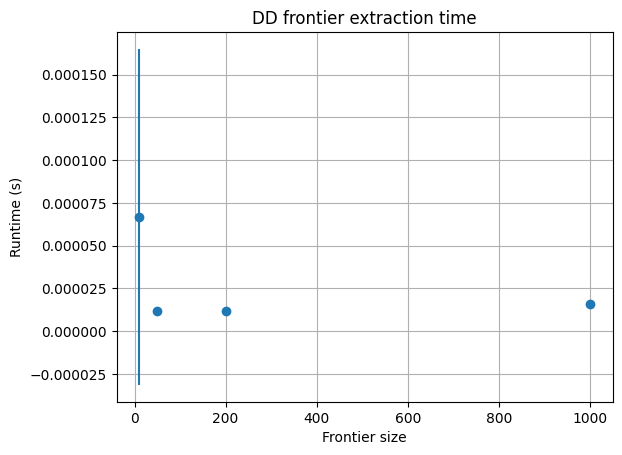

In [6]:
plt.figure()
plt.errorbar(dd_df['frontier'], dd_df['mean_time'], yerr=dd_df['std_time'], fmt='o')
plt.xlabel('Frontier size')
plt.ylabel('Runtime (s)')
plt.title('DD frontier extraction time')
plt.grid(True)
plt.show()


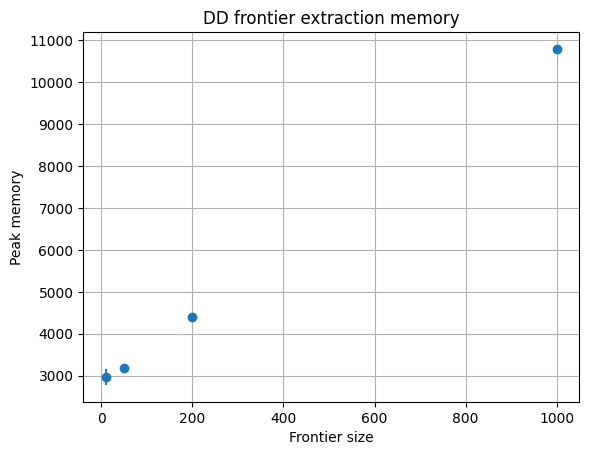

In [7]:
plt.figure()
plt.errorbar(dd_df['frontier'], dd_df['mean_mem'], yerr=dd_df['std_mem'], fmt='o')
plt.xlabel('Frontier size')
plt.ylabel('Peak memory')
plt.title('DD frontier extraction memory')
plt.grid(True)
plt.show()


In [8]:
windows = list(range(2, 17))
reps = 5
st_results = []
for w in windows:
    runner = BenchmarkRunner()
    times = []
    mems = []
    for _ in range(reps):
        rec = runner.run_multiple(w, lambda win: sum(range(1 << win)), repetitions=3)
        times.append(rec['run_time_mean'])
        mems.append(rec['run_peak_memory_mean'])
    st_results.append({
        'window': w,
        'mean_time': np.mean(times),
        'std_time': np.std(times),
        'mean_mem': np.mean(mems),
        'std_mem': np.std(mems)
    })
st_df = pd.DataFrame(st_results)
st_df

,window,mean_time,std_time,mean_mem,std_mem
0,2,0.000007,1.613860e-06,152.000000,0.000000
1,3,0.000006,7.549730e-07,152.000000,0.000000
2,4,0.000006,5.519538e-07,152.000000,0.000000
3,5,0.000007,7.971246e-08,152.000000,0.000000
4,6,0.000007,2.351639e-07,152.000000,0.000000
5,7,0.000008,5.285093e-07,152.000000,0.000000
6,8,0.000008,4.668055e-07,156.266667,8.533333


In [9]:
st_df

,window,mean_time,std_time,mean_mem,std_mem
0,2,0.000007,1.613860e-06,152.000000,0.000000
1,3,0.000006,7.549730e-07,152.000000,0.000000
2,4,0.000006,5.519538e-07,152.000000,0.000000
3,5,0.000007,7.971246e-08,152.000000,0.000000
4,6,0.000007,2.351639e-07,152.000000,0.000000
5,7,0.000008,5.285093e-07,152.000000,0.000000
6,8,0.000008,4.668055e-07,156.266667,8.533333


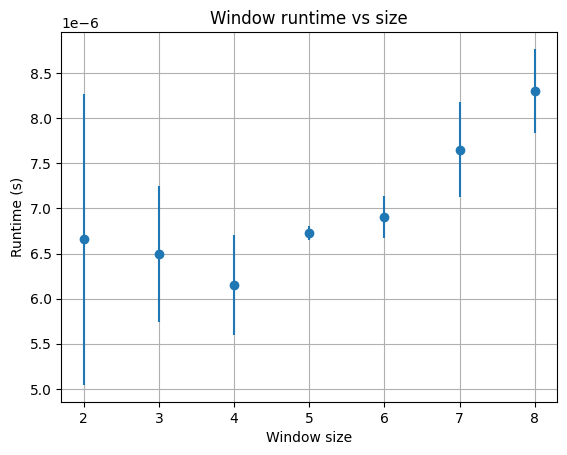

In [10]:
plt.figure()
plt.errorbar(st_df['window'], st_df['mean_time'], yerr=st_df['std_time'], fmt='o')
plt.xlabel('Window size')
plt.ylabel('Runtime (s)')
plt.title('Window runtime vs size')
plt.grid(True)
plt.show()


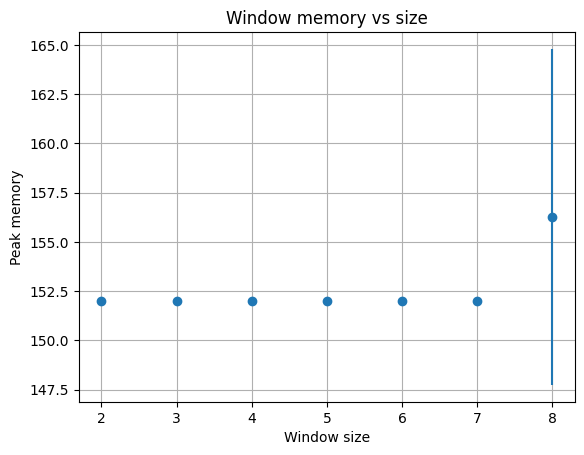

In [11]:
plt.figure()
plt.errorbar(st_df['window'], st_df['mean_mem'], yerr=st_df['std_mem'], fmt='o')
plt.xlabel('Window size')
plt.ylabel('Peak memory')
plt.title('Window memory vs size')
plt.grid(True)
plt.show()


In [12]:
import pandas as pd
from benchmarks.stats_utils import stats_table

def add_stats(df, quasar_col='QuASAr', baseline_cols=None, test='ttest', correction='bonferroni'):
    """Compute statistics comparing QuASAr with baselines.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame with per-circuit results. One column must correspond to QuASAr,
        others to baselines.
    quasar_col : str
        Name of the column containing QuASAr results.
    baseline_cols : list[str] | None
        Columns to treat as baselines. Defaults to all columns except quasar_col.
    test : str
        'ttest' or 'wilcoxon'.
    correction : str
        'bonferroni' or 'fdr_bh'.

    Returns
    -------
    pd.DataFrame
        Table with baseline name, statistic, corrected p-value, and effect size.
    """
    if baseline_cols is None:
        baseline_cols = [c for c in df.columns if c != quasar_col]
    baselines = {c: df[c] for c in baseline_cols}
    return stats_table(df[quasar_col], baselines, test=test, correction=correction)

# Example usage after computing results DataFrame named `results_df`:
# stats_df = add_stats(results_df)
# stats_df


In [13]:

# Record parameters and results
import json, pathlib
try:
    import ipynbname
    nb_name = ipynbname.path().stem
except Exception:  # pragma: no cover
    nb_name = 'notebook'

# Collect simple parameters from globals
_params = {
    k: v for k, v in globals().items()
    if not k.startswith('_') and isinstance(v, (int, float, str, bool, list, dict, tuple))
}
pathlib.Path('../results').mkdir(exist_ok=True)
with open(f"../results/{nb_name}_params.json", 'w') as f:
    json.dump(_params, f, indent=2, default=str)
if 'results' in globals():
    try:
        with open(f"../results/{nb_name}_results.json", 'w') as f:
            json.dump(results, f, indent=2, default=str)
    except TypeError:
        pass
print(json.dumps(_params, indent=2, default=str))


{
  "In": [
    "",
    "import numpy as np\nimport pandas as pd\nimport matplotlib.pyplot as plt\nfrom benchmarks.runner import BenchmarkRunner",
    "chis = [8, 16, 32, 64, 128]\nreps = 5\nsvd_results = []\nfor chi in chis:\n    runner = BenchmarkRunner()\n    times = []\n    mems = []\n    for _ in range(reps):\n        mat = np.random.randn(chi, chi)\n        rec = runner.run_multiple(mat, lambda m: np.linalg.svd(m, full_matrices=False), repetitions=3)\n        times.append(rec['run_time_mean'])\n        mems.append(rec['run_peak_memory_mean'])\n    svd_results.append({\n        'chi': chi,\n        'mean_time': np.mean(times),\n        'std_time': np.std(times),\n        'mean_mem': np.mean(mems),\n        'std_mem': np.std(mems)\n    })\nsvd_df = pd.DataFrame(svd_results)\nsvd_df",
    "plt.figure()\nplt.errorbar(svd_df['chi'], svd_df['mean_time'], yerr=svd_df['std_time'], fmt='o')\nplt.xscale('log')\nplt.yscale('log')\nplt.xlabel(r'$\\chi$')\nplt.ylabel('Runtime (s)')\nplt.title

## Imported from `02_end_to_end.ipynb`

# End-to-End Benchmark

Run QuASAr and baseline backends on benchmark circuits and compare performance.

In [ ]:
import os, sys
sys.path.append(os.path.abspath('../..'))
import pandas as pd
from benchmarks.runner import BenchmarkRunner
from benchmarks.backends import StatevectorAdapter, DecisionDiagramAdapter, MPSAdapter, StimAdapter
from benchmarks import circuits
from quasar.simulation_engine import SimulationEngine
from quasar_convert import ConversionEngine
import time, matplotlib.pyplot as plt

In [ ]:
class TrackingConversionEngine(ConversionEngine):
    def __init__(self):
        super().__init__()
        self.total_time = 0.0
    def _timeit(self, func, *args, **kwargs):
        start = time.perf_counter()
        res = func(*args, **kwargs)
        self.total_time += time.perf_counter() - start
        return res
    def convert_boundary_to_statevector(self, ssd):
        return self._timeit(super().convert_boundary_to_statevector, ssd)
    def convert_boundary_to_tableau(self, ssd):
        if hasattr(super(), "convert_boundary_to_tableau"):
            return self._timeit(super().convert_boundary_to_tableau, ssd)
        raise AttributeError
    def convert_boundary_to_dd(self, ssd):
        if hasattr(super(), "convert_boundary_to_dd"):
            return self._timeit(super().convert_boundary_to_dd, ssd)
        raise AttributeError
    def extract_local_window(self, state, qubits):
        return self._timeit(super().extract_local_window, state, qubits)
    def build_bridge_tensor(self, left, right):
        return self._timeit(super().build_bridge_tensor, left, right)

In [ ]:
circuit_fns = {
    'ghz': circuits.ghz_circuit,
    'qft': circuits.qft_circuit,
    'w_state': circuits.w_state_circuit,
    'grover': circuits.grover_circuit,
}
backends = {
    'statevector': StatevectorAdapter(),
    'mqt_dd': DecisionDiagramAdapter(),
    'mps': MPSAdapter(),
    'stim': StimAdapter(),
}
REPETITIONS = 5
NUM_QUBITS = 16
records = []
for cname, cfn in circuit_fns.items():
    circuit = cfn(NUM_QUBITS)
    for bname, backend in backends.items():
        for _ in range(REPETITIONS):
            runner = BenchmarkRunner()
            try:
                rec = runner.run_multiple(circuit, backend, return_state=False, repetitions=3)
            except (NotImplementedError, RuntimeError):
                continue
            rec.update({'circuit': cname, 'backend_switches': 0, 'conversion_time': 0.0})
            records.append(rec)
    for _ in range(REPETITIONS):
        ce = TrackingConversionEngine()
        runner = BenchmarkRunner()
        engine = SimulationEngine(conversion_engine=ce)
        rec = runner.run_quasar(circuit, engine)
        rec.update({'circuit': cname,
                    'backend_switches': len(rec['result'].conversions),
                    'conversion_time': ce.total_time})
        records.append(rec)
df = pd.DataFrame(records)
df['runtime'] = df['total_time_mean'].fillna(df['total_time'])
df['peak_memory'] = df[['prepare_peak_memory', 'run_peak_memory', 'prepare_peak_memory_mean', 'run_peak_memory_mean']].max(axis=1)
summary = df.groupby(['circuit','framework']).agg(
    runtime_mean=('runtime','mean'), runtime_std=('runtime','std'),
    peak_memory_mean=('peak_memory','mean'), peak_memory_std=('peak_memory','std'),
    backend_switches_mean=('backend_switches','mean'),
    backend_switches_std=('backend_switches','std'),
    conversion_time_mean=('conversion_time','mean'),
    conversion_time_std=('conversion_time','std')
).reset_index()
ghz_backend = df[(df.circuit == 'ghz') & (df.framework == 'quasar')]['backend'].unique()
assert len(ghz_backend) == 1 and ghz_backend[0].lower() in {'stim', 'tableau'}, f'GHZ routed to {ghz_backend}'
summary


In [0]:
runtime_mean = summary.pivot(index='circuit', columns='framework', values='runtime_mean')
runtime_std = summary.pivot(index='circuit', columns='framework', values='runtime_std')
ax = runtime_mean.plot.bar(yerr=runtime_std, capsize=4)
ax.set_ylabel('Runtime (s)')
ax.set_xlabel('Circuit')
plt.tight_layout()

peak_mean = summary.pivot(index='circuit', columns='framework', values='peak_memory_mean')
peak_std = summary.pivot(index='circuit', columns='framework', values='peak_memory_std')
ax = peak_mean.plot.bar(yerr=peak_std, capsize=4)
ax.set_ylabel('Peak memory (B)')
ax.set_xlabel('Circuit')
plt.tight_layout()


In [ ]:
speedup = []
for cname in circuit_fns:
    quasar_time = summary[(summary.circuit==cname)&(summary.framework=='quasar')]['runtime_mean'].iloc[0]
    baseline_times = summary[(summary.circuit==cname)&(summary.framework!='quasar')]['runtime_mean']
    if not baseline_times.empty:
        best_baseline = baseline_times.min()
        speedup.append({'circuit': cname, 'speedup': best_baseline/quasar_time})
speedup_df = pd.DataFrame(speedup)
speedup_df

In [ ]:
ax = speedup_df.plot.bar(x='circuit', y='speedup', legend=False)
ax.set_ylabel('QuASAr speedup over best baseline')
ax.set_xlabel('Circuit')
plt.tight_layout()

In [ ]:
import pandas as pd
from benchmarks.stats_utils import stats_table

def add_stats(df, quasar_col='QuASAr', baseline_cols=None, test='ttest', correction='bonferroni'):
    """Compute statistics comparing QuASAr with baselines.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame with per-circuit results. One column must correspond to QuASAr,
        others to baselines.
    quasar_col : str
        Name of the column containing QuASAr results.
    baseline_cols : list[str] | None
        Columns to treat as baselines. Defaults to all columns except quasar_col.
    test : str
        'ttest' or 'wilcoxon'.
    correction : str
        'bonferroni' or 'fdr_bh'.

    Returns
    -------
    pd.DataFrame
        Table with baseline name, statistic, corrected p-value, and effect size.
    """
    if baseline_cols is None:
        baseline_cols = [c for c in df.columns if c != quasar_col]
    baselines = {c: df[c] for c in baseline_cols}
    return stats_table(df[quasar_col], baselines, test=test, correction=correction)

# Example usage after computing results DataFrame named `results_df`:
# stats_df = add_stats(results_df)
# stats_df


In [ ]:

# Record parameters and results
import json, pathlib
try:
    import ipynbname
    nb_name = ipynbname.path().stem
except Exception:  # pragma: no cover
    nb_name = 'notebook'

# Collect simple parameters from globals
_params = {
    k: v for k, v in globals().items()
    if not k.startswith('_') and isinstance(v, (int, float, str, bool, list, dict, tuple))
}
pathlib.Path('../results').mkdir(exist_ok=True)
with open(f"../results/{nb_name}_params.json", 'w') as f:
    try:
        json.dump(_params, f, indent=2, default=str)
    except TypeError:
        pass
if 'results' in globals():
    try:
        with open(f"../results/{nb_name}_results.json", 'w') as f:
            json.dump(results, f, indent=2, default=str)
    except TypeError:
        pass
try:
    print(json.dumps(_params, indent=2, default=str))
except TypeError:
    print(_params)


## Imported from `03_switching_ablation.ipynb`

# Switching Ablation

This notebook studies how scaling conversion costs by a factor $\alpha$ and enabling the planner's pre-pass cost comparison impacts
QuASAr's backend selection and runtime.  For a small set of representative
circuits we evaluate $\alpha \in \{0.5, 1, 2, 5\}$ and visualise the resulting
plans.


In [1]:
import inspect
import sys, time, pathlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Make project root importable
root = pathlib.Path('..', '..').resolve()
sys.path.append(str(root))

from quasar.planner import Planner
from quasar.simulation_engine import SimulationEngine
from benchmarks.circuits import ghz_circuit, grover_circuit


In [2]:
alphas = [0.5, 1, 2, 5]
circuits = {
    'GHZ_6': ghz_circuit(6),
    'Grover_3': grover_circuit(3, 1),
}
records = []
for name, circ in circuits.items():
    for alpha in alphas:
        kwargs = {'conversion_cost_multiplier': alpha}
        if 'compare_pre_pass_costs' in inspect.signature(Planner).parameters:
            kwargs['compare_pre_pass_costs'] = True
        planner = Planner(**kwargs)
        engine = SimulationEngine(planner=planner)
        start = time.perf_counter()
        result = engine.simulate(circ)
        elapsed = time.perf_counter() - start
        steps = [s.backend.name for s in result.plan.steps]
        records.append({'circuit': name, 'alpha': alpha, 'steps': steps, 'runtime': elapsed})
records
results = records
circuits = list(circuits.keys())


/tmp/ipykernel_5620/2497480058.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  heat_numeric = heat.replace(mapping).astype(float)


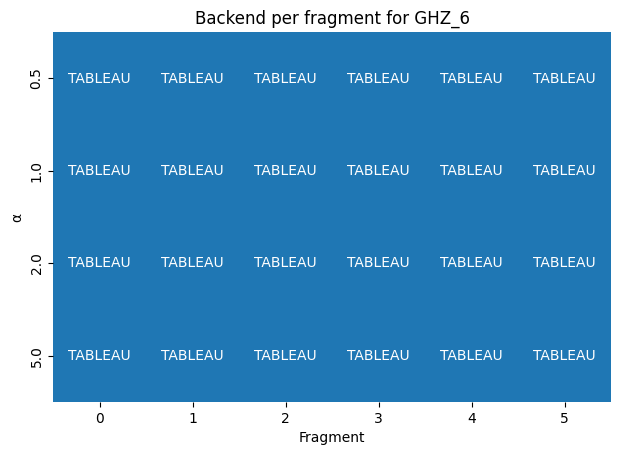

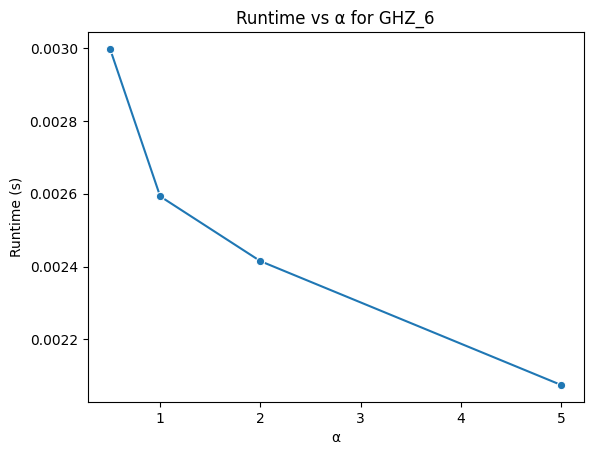

/tmp/ipykernel_5620/2497480058.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  heat_numeric = heat.replace(mapping).astype(float)


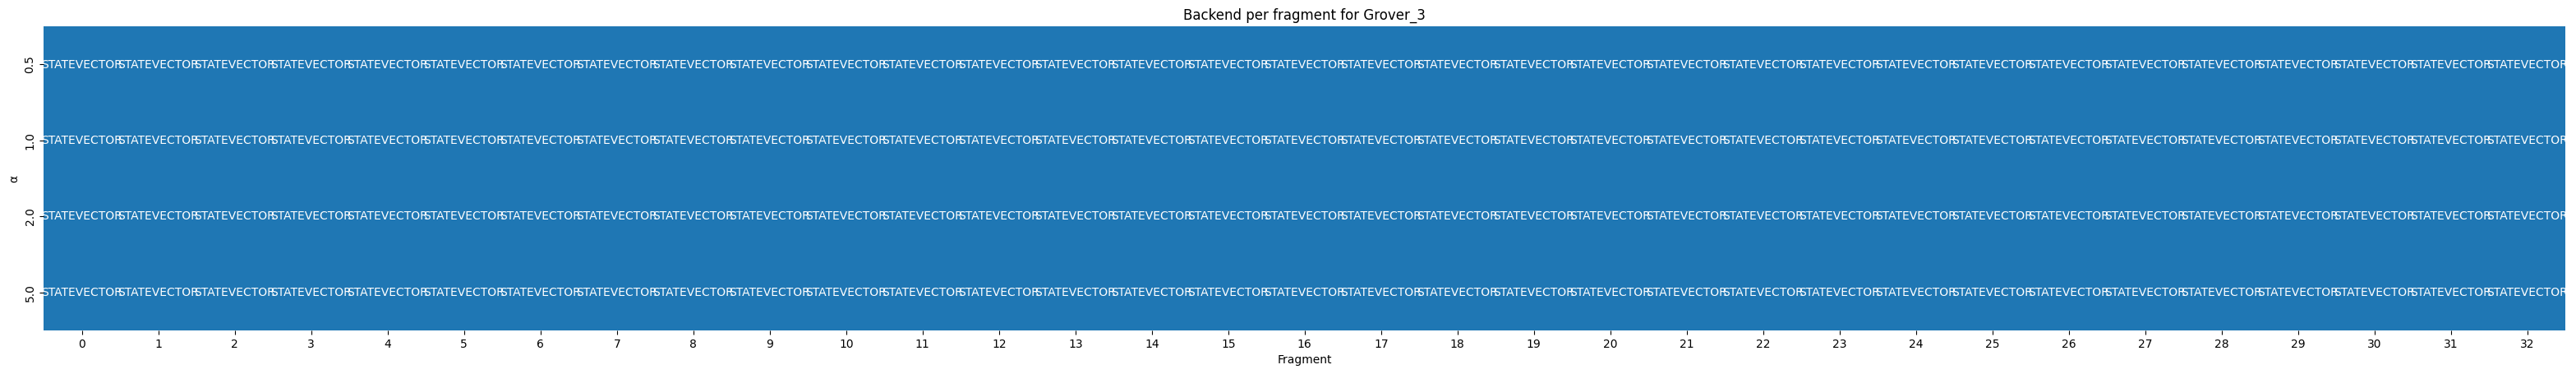

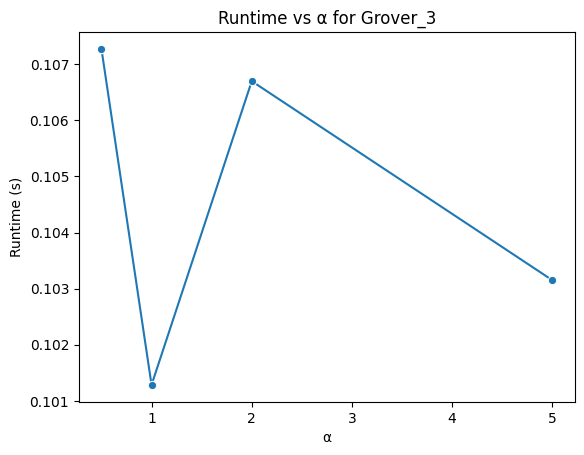

In [3]:
for name in circuits:
    subset = [r for r in records if r['circuit'] == name]
    max_frag = max(len(r['steps']) for r in subset)
    heat = pd.DataFrame(index=alphas, columns=range(max_frag))
    for r in subset:
        heat.loc[r['alpha'], :len(r['steps'])-1] = r['steps']
    backends = sorted({b for row in heat.values for b in row if b is not None})
    mapping = {b: i for i, b in enumerate(backends)}
    heat_numeric = heat.replace(mapping).astype(float)
    plt.figure(figsize=(1.2*max_frag, 1.2*len(alphas)))
    sns.heatmap(heat_numeric, annot=heat, fmt='', cmap='tab10', cbar=False)
    plt.title(f'Backend per fragment for {name}')
    plt.xlabel('Fragment')
    plt.ylabel('α')
    plt.show()

    runtime_df = pd.DataFrame({'alpha': [r['alpha'] for r in subset],
                               'runtime': [r['runtime'] for r in subset]})
    plt.figure()
    sns.lineplot(data=runtime_df, x='alpha', y='runtime', marker='o')
    plt.title(f'Runtime vs α for {name}')
    plt.xlabel('α')
    plt.ylabel('Runtime (s)')
    plt.show()


The plots above illustrate how enabling the pre-pass comparison guides backend selection and affects runtime across different conversion cost multipliers. In this configuration GHZ_6 remains on the TABLEAU backend for all $\alpha$, while Grover_3 consistently uses STATEVECTOR with only minor runtime variation.


In [4]:
import pandas as pd
from benchmarks.stats_utils import stats_table

def add_stats(df, quasar_col='QuASAr', baseline_cols=None, test='ttest', correction='bonferroni'):
    """Compute statistics comparing QuASAr with baselines.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame with per-circuit results. One column must correspond to QuASAr,
        others to baselines.
    quasar_col : str
        Name of the column containing QuASAr results.
    baseline_cols : list[str] | None
        Columns to treat as baselines. Defaults to all columns except quasar_col.
    test : str
        'ttest' or 'wilcoxon'.
    correction : str
        'bonferroni' or 'fdr_bh'.

    Returns
    -------
    pd.DataFrame
        Table with baseline name, statistic, corrected p-value, and effect size.
    """
    if baseline_cols is None:
        baseline_cols = [c for c in df.columns if c != quasar_col]
    baselines = {c: df[c] for c in baseline_cols}
    return stats_table(df[quasar_col], baselines, test=test, correction=correction)

# Example usage after computing results DataFrame named `results_df`:
# stats_df = add_stats(results_df)
# stats_df


In [5]:

# Record parameters and results
import json, pathlib
try:
    import ipynbname
    nb_name = ipynbname.path().stem
except Exception:  # pragma: no cover
    nb_name = 'notebook'

# Collect simple parameters from globals
_params = {
    k: v for k, v in globals().items()
    if not k.startswith('_') and isinstance(v, (int, float, str, bool, list, dict, tuple))
}
pathlib.Path('../results').mkdir(exist_ok=True)
with open(f"../results/{nb_name}_params.json", 'w') as f:
    json.dump(_params, f, indent=2, default=str)
if 'results' in globals():
    try:
        with open(f"../results/{nb_name}_results.json", 'w') as f:
            json.dump(results, f, indent=2, default=str)
    except TypeError:
        pass
print(json.dumps(_params, indent=2, default=str))


{
  "In": [
    "",
    "import inspect\nimport sys, time, pathlib\nimport pandas as pd\nimport seaborn as sns\nimport matplotlib.pyplot as plt\n\n# Make project root importable\nroot = pathlib.Path('..', '..').resolve()\nsys.path.append(str(root))\n\nfrom quasar.planner import Planner\nfrom quasar.simulation_engine import SimulationEngine\nfrom benchmarks.circuits import ghz_circuit, grover_circuit",
    "alphas = [0.5, 1, 2, 5]\ncircuits = {\n    'GHZ_6': ghz_circuit(6),\n    'Grover_3': grover_circuit(3, 1),\n}\nrecords = []\nfor name, circ in circuits.items():\n    for alpha in alphas:\n        kwargs = {'conversion_cost_multiplier': alpha}\n        if 'compare_pre_pass_costs' in inspect.signature(Planner).parameters:\n            kwargs['compare_pre_pass_costs'] = True\n        planner = Planner(**kwargs)\n        engine = SimulationEngine(planner=planner)\n        start = time.perf_counter()\n        result = engine.simulate(circ)\n        elapsed = time.perf_counter() - start\n 

## Imported from `04_planner_quality.ipynb`

# Planner quality

This notebook compares exhaustive oracle, greedy, and dynamic programming strategies on small circuits (≤ 20 qubits) using the planner's public interface and updated cost heuristics (entanglement-aware MPS, decision-diagram weighting).


In [ ]:
import time, random, importlib, subprocess, sys, numpy as np
from quasar.cost import CostEstimator, Cost, Backend
from quasar.planner import Planner, PlanStep
from quasar.partitioner import CLIFFORD_GATES
from quasar import config
from quasar.circuit import Circuit
from benchmarks import circuits as circuit_lib

# ensure required libraries
for pkg in ["pandas", "matplotlib"]:
    if importlib.util.find_spec(pkg) is None:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg, "-q"])
import pandas as pd
import matplotlib.pyplot as plt


def add_cost(a, b):
    return Cost(
        time=a.time + b.time,
        memory=max(a.memory, b.memory),
        log_depth=max(a.log_depth, b.log_depth),
        conversion=a.conversion + b.conversion,
        replay=a.replay + b.replay,
    )


def better(a, b):
    return (a.time, a.memory) < (b.time, b.memory)


def simulation_cost(estimator, backend, num_qubits, num_1q_gates, num_2q_gates, num_meas):
    if backend == Backend.TABLEAU:
        return estimator.tableau(num_qubits, num_1q_gates + num_2q_gates + num_meas)
    if backend == Backend.MPS:
        chi = estimator.chi_max or 1
        return estimator.mps(num_qubits, num_1q_gates + num_meas, num_2q_gates, chi, svd=True)
    if backend == Backend.DECISION_DIAGRAM:
        return estimator.decision_diagram(num_gates=num_1q_gates + num_2q_gates + num_meas, frontier=num_qubits)
    return estimator.statevector(num_qubits, num_1q_gates, num_2q_gates, num_meas)


def supported_backends(gates, *, circuit=None, allow_tableau=True, estimator=None, max_memory=None):
    if circuit is None:
        circuit = Circuit(gates)
    names = [g.gate.upper() for g in gates]
    clifford = names and all(name in CLIFFORD_GATES for name in names)
    if allow_tableau and clifford:
        return [Backend.TABLEAU]

    sym = getattr(circuit, "symmetry", 0.0)
    sparse = getattr(circuit, "sparsity", 0.0)
    score = (
        config.DEFAULT.dd_symmetry_weight * sym
        + config.DEFAULT.dd_sparsity_weight * sparse
    )
    dd_metric = score >= config.DEFAULT.dd_metric_threshold

    mps_metric = False
    if estimator is not None and all(len(g.qubits) <= 2 for g in gates):
        chi_cap = estimator.chi_max
        if chi_cap is not None and chi_cap >= 1:
            num_meas = sum(1 for g in gates if g.gate.upper() in {"MEASURE", "RESET"})
            num_1q = sum(
                1
                for g in gates
                if len(g.qubits) == 1 and g.gate.upper() not in {"MEASURE", "RESET"}
            )
            num_2q = len(gates) - num_1q - num_meas
            num_qubits = len({q for g in gates for q in g.qubits})
            cost = estimator.mps(num_qubits, num_1q + num_meas, num_2q, chi_cap)
            if max_memory is None or cost.memory <= max_memory:
                mps_metric = True

    candidates = []
    if dd_metric:
        candidates.append(Backend.DECISION_DIAGRAM)
    if mps_metric:
        candidates.append(Backend.MPS)
    candidates.append(Backend.STATEVECTOR)
    return candidates


def build_boundaries(gates):
    n = len(gates)
    prefix = [set()]
    running = set()
    for g in gates:
        running |= set(g.qubits)
        prefix.append(running.copy())
    future = [set() for _ in range(n + 1)]
    running = set()
    for i in range(n - 1, -1, -1):
        running |= set(gates[i].qubits)
        future[i] = running.copy()
    boundaries = [prefix[i] & future[i] for i in range(n + 1)]
    return boundaries


def exhaustive_plan(gates, planner):
    est = planner.estimator
    n = len(gates)
    boundaries = build_boundaries(gates)
    best_cost = None

    def recurse(i, prev_backend, cost):
        nonlocal best_cost
        if i == n:
            if best_cost is None or better(cost, best_cost):
                best_cost = cost
            return
        for j in range(i + 1, n + 1):
            segment = gates[i:j]
            cand_circ = Circuit(segment)
            backends = supported_backends(segment, circuit=cand_circ, estimator=est)
            num_qubits = cand_circ.num_qubits
            num_gates = j - i
            num_meas = sum(1 for g in segment if g.gate.upper() in {"MEASURE", "RESET"})
            num_1q = sum(
                1
                for g in segment
                if len(g.qubits) == 1 and g.gate.upper() not in {"MEASURE", "RESET"}
            )
            num_2q = num_gates - num_1q - num_meas
            for backend in backends:
                sim_cost = simulation_cost(est, backend, num_qubits, num_1q, num_2q, num_meas)
                conv_cost = Cost(0.0, 0.0)
                if prev_backend is not None and prev_backend != backend and boundaries[i]:
                    bsize = len(boundaries[i])
                    conv_est = est.conversion(
                        prev_backend,
                        backend,
                        num_qubits=bsize,
                        rank=2 ** bsize,
                        frontier=bsize,
                    )
                    conv_cost = conv_est.cost
                total = add_cost(add_cost(cost, conv_cost), sim_cost)
                recurse(j, backend, total)

    recurse(0, None, Cost(0.0, 0.0))
    return best_cost


def greedy_plan(gates, planner):
    est = planner.estimator
    n = len(gates)
    boundaries = build_boundaries(gates)
    total = Cost(0.0, 0.0)
    i = 0
    prev_backend = None
    while i < n:
        best_inc = None
        best_end = None
        best_backend = None
        for j in range(i + 1, n + 1):
            segment = gates[i:j]
            cand_circ = Circuit(segment)
            backends = supported_backends(segment, circuit=cand_circ, estimator=est)
            num_qubits = cand_circ.num_qubits
            num_gates = j - i
            num_meas = sum(1 for g in segment if g.gate.upper() in {"MEASURE", "RESET"})
            num_1q = sum(
                1
                for g in segment
                if len(g.qubits) == 1 and g.gate.upper() not in {"MEASURE", "RESET"}
            )
            num_2q = num_gates - num_1q - num_meas
            for backend in backends:
                sim_cost = simulation_cost(est, backend, num_qubits, num_1q, num_2q, num_meas)
                conv_cost = Cost(0.0, 0.0)
                if prev_backend is not None and prev_backend != backend and boundaries[i]:
                    bsize = len(boundaries[i])
                    conv_est = est.conversion(
                        prev_backend,
                        backend,
                        num_qubits=bsize,
                        rank=2 ** bsize,
                        frontier=bsize,
                    )
                    conv_cost = conv_est.cost
                inc = add_cost(conv_cost, sim_cost)
                if best_inc is None or better(inc, best_inc):
                    best_inc = inc
                    best_end = j
                    best_backend = backend
        total = add_cost(total, best_inc)
        prev_backend = best_backend
        i = best_end
    return total


In [ ]:
est=CostEstimator()
planner=Planner(estimator=est, top_k=2, quick_max_qubits=None, quick_max_gates=None, quick_max_depth=None)

results=[]
for seed in range(10):
    num_qubits = random.randint(20,50)
    circuit = circuit_lib.random_circuit(num_qubits, seed=seed)
    gates=circuit.gates[:8]
    c=Circuit(gates)
    est.chi_max = est.chi_for_fidelity(c.num_qubits, gates, fidelity=0.99)
    start=time.perf_counter(); oracle=exhaustive_plan(gates, planner); t_oracle=time.perf_counter()-start
    start=time.perf_counter(); planres=planner.plan(c, use_cache=False); t_dp=time.perf_counter()-start
    dp_cost=planres.table[-1][planres.final_backend].cost if planres.table else Cost(0.0,0.0)
    start=time.perf_counter(); greedy=greedy_plan(gates, planner); t_greedy=time.perf_counter()-start
    results.append({
        "seed":seed,
        "qubits":c.num_qubits,
        "gates":len(gates),
        "oracle":oracle.time,
        "dp":dp_cost.time,
        "greedy":greedy.time,
        "t_oracle":t_oracle,
        "t_dp":t_dp,
        "t_greedy":t_greedy,
        "gap":dp_cost.time/oracle.time - 1,
    })

df=pd.DataFrame(results)
df


In [ ]:
sorted_gaps=np.sort(df["gap"])
ys=np.arange(1,len(sorted_gaps)+1)/len(sorted_gaps)
plt.step(sorted_gaps, ys, where="post")
plt.xlabel("Relative cost gap (DP vs oracle)")
plt.ylabel("CDF")
plt.title("Planner gap with updated cost model")
plt.tight_layout()


The dynamic programming planner, equipped with entanglement-aware MPS and symmetry-weighted decision-diagram heuristics, closely follows the exhaustive oracle cost while outperforming a greedy baseline.

In [ ]:
import pandas as pd
from benchmarks.stats_utils import stats_table

def add_stats(df, quasar_col='QuASAr', baseline_cols=None, test='ttest', correction='bonferroni'):
    """Compute statistics comparing QuASAr with baselines.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame with per-circuit results. One column must correspond to QuASAr,
        others to baselines.
    quasar_col : str
        Name of the column containing QuASAr results.
    baseline_cols : list[str] | None
        Columns to treat as baselines. Defaults to all columns except quasar_col.
    test : str
        'ttest' or 'wilcoxon'.
    correction : str
        'bonferroni' or 'fdr_bh'.

    Returns
    -------
    pd.DataFrame
        Table with baseline name, statistic, corrected p-value, and effect size.
    """
    if baseline_cols is None:
        baseline_cols = [c for c in df.columns if c != quasar_col]
    baselines = {c: df[c] for c in baseline_cols}
    return stats_table(df[quasar_col], baselines, test=test, correction=correction)

# Example usage after computing results DataFrame named `results_df`:
# stats_df = add_stats(results_df)
# stats_df


In [ ]:

# Record parameters and results
import json, pathlib
try:
    import ipynbname
    nb_name = ipynbname.path().stem
except Exception:  # pragma: no cover
    nb_name = 'notebook'

# Collect simple parameters from globals
_params = {
    k: v for k, v in globals().items()
    if not k.startswith('_') and isinstance(v, (int, float, str, bool, list, dict, tuple))
}
pathlib.Path('../results').mkdir(exist_ok=True)
with open(f"../results/{nb_name}_params.json", 'w') as f:
    json.dump(_params, f, indent=2, default=str)
if 'results' in globals():
    try:
        with open(f"../results/{nb_name}_results.json", 'w') as f:
            json.dump(results, f, indent=2, default=str)
    except TypeError:
        pass
print(json.dumps(_params, indent=2, default=str))


## Imported from `05_robustness.ipynb`

# Robustness to Execution Perturbations

This notebook evaluates the scheduler's ability to recover from unexpected changes. Two perturbation types are applied during execution:

* **Gate injection** – extra entangling operations are inserted while the circuit is already running.
* **Cost corruption** – cost model coefficients are perturbed to trigger re-planning.

For each magnitude we perform multiple repetitions, measuring the time to recover and the runtime overhead. Timelines highlight when re-planning occurs and a table summarises recovery statistics.

In [ ]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from quasar.circuit import Gate
from quasar.scheduler import Scheduler
from quasar.planner import Planner
from quasar.config import Backend
from benchmarks import circuits

plt.rcParams['figure.dpi'] = 120

_circuit_factories = {
    'ghz': lambda: circuits.ghz_circuit(5),
    'grover': lambda: circuits.grover_circuit(5),
}


In [ ]:
# Baseline runtime and memory

def measure_baseline(circuit_fn, backend_hint=None):
    sched = Scheduler(planner=Planner(), quick_max_gates=0)
    _, cost = sched.run(circuit_fn(), instrument=True, backend=backend_hint)
    return cost.time, cost.memory

baselines = {
    name: measure_baseline(fn, backend_hint=Backend.TABLEAU if name == 'ghz' else None)
    for name, fn in _circuit_factories.items()
}
baselines


In [ ]:
# Perturbation helpers

def run_gate_perturbation(circuit_fn, baseline, magnitude, repetitions=5, *, enforce_stim=False, circuit_name=''):
    records = []
    for _ in range(repetitions):
        circuit = circuit_fn()
        scheduler = Scheduler(planner=Planner(), quick_max_gates=0)
        timeline = []
        info = {}
        step_idx = {'i': 0}
        peak_memory = 0.0

        def monitor(step, observed, est):
            nonlocal peak_memory
            now = time.perf_counter() - start
            start_t = timeline[-1]['end'] if timeline else 0.0
            timeline.append({
                'step': step_idx['i'],
                'start': start_t,
                'end': now,
                'backend': step.backend.name,
                'memory': observed.memory,
            })
            peak_memory = max(peak_memory, observed.memory)
            step_idx['i'] += 1
            if 'trigger' not in info:
                circuit.gates[step.end:step.end] = [Gate('T', [0])] * magnitude
                info['trigger'] = now
                return True
            return False

        start = time.perf_counter()
        scheduler.run(
            circuit,
            monitor=monitor,
            instrument=True,
            backend=Backend.TABLEAU if enforce_stim else None,
        )
        total = time.perf_counter() - start
        backend_switches = sum(
            timeline[i]['backend'] != timeline[i - 1]['backend']
            for i in range(1, len(timeline))
        )
        records.append({
            'circuit': circuit_name,
            'perturb': 'gate',
            'magnitude': magnitude,
            'total_time': total,
            'recovery_time': total - info['trigger'],
            'overhead': total - baseline[0],
            'peak_memory': peak_memory,
            'memory_overhead': peak_memory - baseline[1],
            'backend_switches': backend_switches,
            'timeline': timeline,
            'trigger_time': info['trigger'],
            'backends': [seg['backend'] for seg in timeline],
        })
    return records


def run_cost_perturbation(circuit_fn, baseline, factor, repetitions=5, *, enforce_stim=False, circuit_name=''):
    records = []
    for _ in range(repetitions):
        circuit = circuit_fn()
        scheduler = Scheduler(planner=Planner(), quick_max_gates=0)
        scheduler.planner.estimator.coeff['sv_gate'] *= factor
        timeline = []
        step_idx = {'i': 0}
        peak_memory = 0.0

        def monitor(step, observed, est):
            nonlocal peak_memory
            now = time.perf_counter() - start
            start_t = timeline[-1]['end'] if timeline else 0.0
            timeline.append({
                'step': step_idx['i'],
                'start': start_t,
                'end': now,
                'backend': step.backend.name,
                'memory': observed.memory,
            })
            peak_memory = max(peak_memory, observed.memory)
            step_idx['i'] += 1
            return False

        start = time.perf_counter()
        scheduler.run(
            circuit,
            monitor=monitor,
            instrument=True,
            backend=Backend.TABLEAU if enforce_stim else None,
        )
        total = time.perf_counter() - start
        trigger = timeline[0]['end'] if timeline else 0.0
        backend_switches = sum(
            timeline[i]['backend'] != timeline[i - 1]['backend']
            for i in range(1, len(timeline))
        )
        records.append({
            'circuit': circuit_name,
            'perturb': 'cost',
            'magnitude': factor,
            'total_time': total,
            'recovery_time': total - trigger,
            'overhead': total - baseline[0],
            'peak_memory': peak_memory,
            'memory_overhead': peak_memory - baseline[1],
            'backend_switches': backend_switches,
            'timeline': timeline,
            'trigger_time': trigger,
            'backends': [seg['backend'] for seg in timeline],
        })
    return records


In [ ]:
# Run experiments

repetitions = 5

gate_magnitudes = [1, 2, 3]
cost_magnitudes = [1e-6, 1e-7, 1e-8]

records = []
for name, fn in _circuit_factories.items():
    baseline = baselines[name]
    enforce = name == 'ghz'
    for m in gate_magnitudes:
        records.extend(run_gate_perturbation(fn, baseline, m, repetitions, enforce_stim=enforce, circuit_name=name))
    for f in cost_magnitudes:
        records.extend(run_cost_perturbation(fn, baseline, f, repetitions, enforce_stim=enforce, circuit_name=name))

results = pd.DataFrame(records)
results.head()


In [ ]:
# Timeline plot for a representative run

sample = results[(results['perturb']=='gate') & (results['magnitude']==gate_magnitudes[0]) & (results['circuit']=='ghz')].iloc[0]
fig, ax = plt.subplots(figsize=(6, 2))
backend_colors = {'TABLEAU': 'tab:blue', 'STATEVECTOR': 'tab:orange', 'MPS': 'tab:green', 'DECISION_DIAGRAM': 'tab:red'}
for seg in sample['timeline']:
    ax.barh(seg['step'], seg['end']-seg['start'], left=seg['start'], color=backend_colors.get(seg['backend'], 'gray'))
ax.axvline(sample['trigger_time'], color='red', linestyle='--', label='re-plan')
handles = [plt.Line2D([0], [0], color=c, lw=4, label=b) for b, c in backend_colors.items()]
handles.append(plt.Line2D([0], [0], color='red', linestyle='--', label='re-plan'))
ax.legend(handles=handles)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Step')
ax.set_title("Switches: {0} | Memory overhead: {1:.0f} B".format(sample['backend_switches'], sample['memory_overhead']))
plt.tight_layout()
plt.show()


In [ ]:
# Summary table of recovery metrics

metrics = results.groupby(['circuit', 'perturb', 'magnitude']).agg(
    recovery_mean=('recovery_time', 'mean'),
    recovery_std=('recovery_time', 'std'),
    overhead_mean=('overhead', 'mean'),
    overhead_std=('overhead', 'std'),
    memory_overhead_mean=('memory_overhead', 'mean'),
    memory_overhead_std=('memory_overhead', 'std'),
    backend_switches_mean=('backend_switches', 'mean'),
).reset_index()
metrics


In [ ]:
import pandas as pd
from benchmarks.stats_utils import stats_table

def add_stats(df, quasar_col='QuASAr', baseline_cols=None, test='ttest', correction='bonferroni'):
    """Compute statistics comparing QuASAr with baselines.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame with per-circuit results. One column must correspond to QuASAr,
        others to baselines.
    quasar_col : str
        Name of the column containing QuASAr results.
    baseline_cols : list[str] | None
        Columns to treat as baselines. Defaults to all columns except quasar_col.
    test : str
        'ttest' or 'wilcoxon'.
    correction : str
        'bonferroni' or 'fdr_bh'.

    Returns
    -------
    pd.DataFrame
        Table with baseline name, statistic, corrected p-value, and effect size.
    """
    if baseline_cols is None:
        baseline_cols = [c for c in df.columns if c != quasar_col]
    baselines = {c: df[c] for c in baseline_cols}
    return stats_table(df[quasar_col], baselines, test=test, correction=correction)

# Example usage after computing results DataFrame named `results_df`:
# stats_df = add_stats(results_df)
# stats_df


In [ ]:

# Record parameters and results
import json, pathlib
try:
    import ipynbname
    nb_name = ipynbname.path().stem
except Exception:  # pragma: no cover
    nb_name = 'notebook'

# Collect simple parameters from globals
_params = {
    k: v for k, v in globals().items()
    if not k.startswith('_') and isinstance(v, (int, float, str, bool, list, dict, tuple)) and not isinstance(v, pd.DataFrame)
}
pathlib.Path('../results').mkdir(exist_ok=True)
with open(f"../results/{nb_name}_params.json", 'w') as f:
    json.dump(_params, f, indent=2, default=str)
if 'results' in globals():
    try:
        with open(f"../results/{nb_name}_results.json", 'w') as f:
            json.dump(results, f, indent=2, default=str)
    except TypeError:
        pass
print(json.dumps(_params, indent=2, default=str))


## Imported from `06_plan_cache.ipynb`

# Plan Cache Exploration
This notebook demonstrates QuASAr's plan cache when executing a parameterized circuit multiple times. It records cache hit rates, cumulative speedup from warm vs cold cache runs, and reuse within the conversion engine.

In [1]:
import time
import tracemalloc
import inspect
import pandas as pd
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
import quasar
import quasar_convert as qconv
from quasar.planner import Planner

In [2]:
def build_circuit(theta1, theta2):
    qc = QuantumCircuit(2)
    qc.rx(theta1, 0)
    qc.cx(0, 1)
    qc.ry(theta2, 1)
    return quasar.Circuit.from_qiskit(qc)

In [3]:

angles = [(0.1,0.2), (0.3,0.4), (0.5,0.6)] * 3
planner_kwargs = {'quick_max_qubits': 0}
if 'compare_pre_pass_costs' in inspect.signature(Planner).parameters:
    planner_kwargs['compare_pre_pass_costs'] = True
planner_cold = Planner(**planner_kwargs)
planner_warm = Planner(**planner_kwargs)
engine = qconv.ConversionEngine()
metrics = []

def time_and_peak_memory(planner, circ, *, use_cache):
    tracemalloc.start()
    t0 = time.time()
    planner.plan(circ, use_cache=use_cache)
    runtime = time.time() - t0
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    return runtime, peak / 1e6  # MB

for idx, (a,b) in enumerate(angles, start=1):
    circ = build_circuit(a,b)
    engine.extract_ssd([0,1], 2)
    cold_time, cold_mem = time_and_peak_memory(planner_cold, circ, use_cache=False)
    warm_time, warm_mem = time_and_peak_memory(planner_warm, circ, use_cache=True)
    metrics.append({'run': idx,
                    'cache_hits': planner_warm.cache_hits,
                    'hit_rate': planner_warm.cache_hits/idx,
                    'conversion_reuse': idx - len(engine._ssd_cache),
                    'cold_time': cold_time,
                    'warm_time': warm_time,
                    'cold_memory': cold_mem,
                    'warm_memory': warm_mem})

import pandas as pd

df = pd.DataFrame(metrics)
df['cum_cold_time'] = df['cold_time'].cumsum()
df['cum_warm_time'] = df['warm_time'].cumsum()
df['cum_cold_memory'] = df['cold_memory'].cumsum()
df['cum_warm_memory'] = df['warm_memory'].cumsum()
df['cumulative_speedup'] = df['cum_cold_time']/df['cum_warm_time']
df['cumulative_memory_savings'] = df['cum_cold_memory']/df['cum_warm_memory']
df[['run','hit_rate','conversion_reuse','cumulative_speedup','cumulative_memory_savings']]


,run,hit_rate,conversion_reuse,cumulative_speedup,cumulative_memory_savings
0,1,0.000000,0,1.113465,1.330990
1,2,0.000000,1,1.099671,1.194979
2,3,0.000000,2,1.072508,1.146917
3,4,0.250000,3,1.418546,1.436366
4,5,0.400000,4,1.732704,1.684964
5,6,0.500000,5,2.056256,1.915395
6,7,0.571429,6,2.363200,2.129708
7,8,0.625000,7,2.757320,2.329500
8,9,0.666667,8,3.111577,2.516339


In [4]:
df[['run','hit_rate','conversion_reuse','cumulative_speedup','cumulative_memory_savings']]


,run,hit_rate,conversion_reuse,cumulative_speedup,cumulative_memory_savings
0,1,0.000000,0,1.113465,1.330990
1,2,0.000000,1,1.099671,1.194979
2,3,0.000000,2,1.072508,1.146917
3,4,0.250000,3,1.418546,1.436366
4,5,0.400000,4,1.732704,1.684964
5,6,0.500000,5,2.056256,1.915395
6,7,0.571429,6,2.363200,2.129708
7,8,0.625000,7,2.757320,2.329500
8,9,0.666667,8,3.111577,2.516339


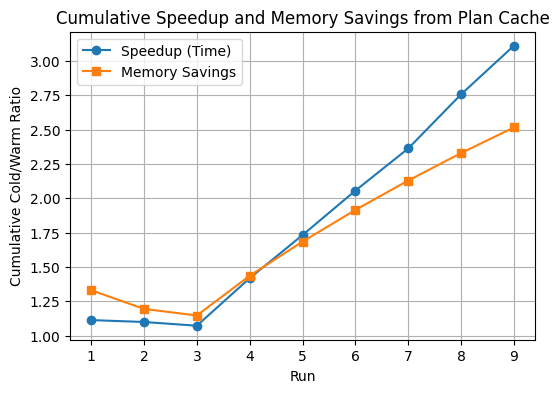

In [5]:

plt.figure(figsize=(6,4))
plt.plot(df['run'], df['cumulative_speedup'], marker='o', label='Speedup (Time)')
plt.plot(df['run'], df['cumulative_memory_savings'], marker='s', label='Memory Savings')
plt.xlabel('Run')
plt.ylabel('Cumulative Cold/Warm Ratio')
plt.title('Cumulative Speedup and Memory Savings from Plan Cache')
plt.grid(True)
plt.legend()
plt.show()


In [6]:
import pandas as pd
from benchmarks.stats_utils import stats_table

def add_stats(df, quasar_col='QuASAr', baseline_cols=None, test='ttest', correction='bonferroni'):
    """Compute statistics comparing QuASAr with baselines.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame with per-circuit results. One column must correspond to QuASAr,
        others to baselines.
    quasar_col : str
        Name of the column containing QuASAr results.
    baseline_cols : list[str] | None
        Columns to treat as baselines. Defaults to all columns except quasar_col.
    test : str
        'ttest' or 'wilcoxon'.
    correction : str
        'bonferroni' or 'fdr_bh'.

    Returns
    -------
    pd.DataFrame
        Table with baseline name, statistic, corrected p-value, and effect size.
    """
    if baseline_cols is None:
        baseline_cols = [c for c in df.columns if c != quasar_col]
    baselines = {c: df[c] for c in baseline_cols}
    return stats_table(df[quasar_col], baselines, test=test, correction=correction)

# Example usage after computing results DataFrame named `results_df`:
# stats_df = add_stats(results_df)
# stats_df


In [7]:

# Record parameters and results
import json, pathlib
try:
    import ipynbname
    nb_name = ipynbname.path().stem
except Exception:  # pragma: no cover
    nb_name = '06_plan_cache'

# Collect simple parameters from globals
_params = {
    k: v for k, v in globals().items()
    if not k.startswith('_') and isinstance(v, (int, float, str, bool, list, dict, tuple))
}
pathlib.Path('../results').mkdir(exist_ok=True)
with open(f"../results/{nb_name}_params.json", 'w') as f:
    json.dump(_params, f, indent=2, default=str)
if 'results' in globals():
    try:
        with open(f"../results/{nb_name}_results.json", 'w') as f:
            json.dump(results, f, indent=2, default=str)
    except TypeError:
        pass
print(json.dumps(_params, indent=2, default=str))


{
  "In": [
    "",
    "import time\nimport tracemalloc\nimport inspect\nimport pandas as pd\nimport matplotlib.pyplot as plt\nfrom qiskit import QuantumCircuit\nimport quasar\nimport quasar_convert as qconv\nfrom quasar.planner import Planner",
    "def build_circuit(theta1, theta2):\n    qc = QuantumCircuit(2)\n    qc.rx(theta1, 0)\n    qc.cx(0, 1)\n    qc.ry(theta2, 1)\n    return quasar.Circuit.from_qiskit(qc)",
    "angles = [(0.1,0.2), (0.3,0.4), (0.5,0.6)] * 3\nplanner_kwargs = {'quick_max_qubits': 0}\nif 'compare_pre_pass_costs' in inspect.signature(Planner).parameters:\n    planner_kwargs['compare_pre_pass_costs'] = True\nplanner_cold = Planner(**planner_kwargs)\nplanner_warm = Planner(**planner_kwargs)\nengine = qconv.ConversionEngine()\nmetrics = []\n\ndef time_and_peak_memory(planner, circ, *, use_cache):\n    tracemalloc.start()\n    t0 = time.time()\n    planner.plan(circ, use_cache=use_cache)\n    runtime = time.time() - t0\n    _, peak = tracemalloc.get_traced_memory()

## Imported from `07_parallelism.ipynb`

# Parallelism Benchmarks
This notebook illustrates the effect of enabling scheduler parallel execution across backends using real simulators.

In [ ]:

from quasar import Circuit, Scheduler
from quasar.cost import Backend
from quasar.backends import StimBackend, MPSBackend
from quasar.planner import Planner
from benchmarks.runner import BenchmarkRunner
import quasar.config as config
import pandas as pd
import matplotlib.pyplot as plt

config.DEFAULT.dd_metric_threshold = 999  # disable decision-diagram backend

runner = BenchmarkRunner()


def stim_circuit(reps: int = 500) -> Circuit:
    ops = []
    for _ in range(reps):
        ops.extend([
            {"gate": "H", "qubits": [0]},
            {"gate": "H", "qubits": [1]},
            {"gate": "CX", "qubits": [0, 1]},
            {"gate": "H", "qubits": [2]},
            {"gate": "H", "qubits": [3]},
            {"gate": "CX", "qubits": [2, 3]},
        ])
    return Circuit(ops)


def mps_circuit(reps: int = 100) -> Circuit:
    ops = []
    for _ in range(reps):
        ops.extend([
            {"gate": "H", "qubits": [0]},
            {"gate": "T", "qubits": [0]},
            {"gate": "CX", "qubits": [0, 1]},
            {"gate": "H", "qubits": [2]},
            {"gate": "T", "qubits": [2]},
            {"gate": "CX", "qubits": [2, 3]},
        ])
    return Circuit(ops)

stim = stim_circuit()
mps = mps_circuit()

# Stim benchmarks
scheduler_stim_parallel = Scheduler(
    backends={Backend.TABLEAU: StimBackend()},
    planner=Planner(backend_order=[Backend.TABLEAU]),
    parallel_backends=[Backend.TABLEAU],
    quick_max_qubits=None,
    quick_max_gates=None,
    quick_max_depth=None,
)

scheduler_stim_serial = Scheduler(
    backends={Backend.TABLEAU: StimBackend()},
    planner=Planner(backend_order=[Backend.TABLEAU]),
    parallel_backends=[],
    quick_max_qubits=None,
    quick_max_gates=None,
    quick_max_depth=None,
)

res_stim_parallel = runner.run_quasar(stim, scheduler_stim_parallel, backend=Backend.TABLEAU)
res_stim_serial = runner.run_quasar(stim, scheduler_stim_serial, backend=Backend.TABLEAU)

# MPS benchmarks
scheduler_mps_parallel = Scheduler(
    backends={Backend.MPS: MPSBackend()},
    planner=Planner(backend_order=[Backend.MPS]),
    parallel_backends=[Backend.MPS],
    quick_max_qubits=None,
    quick_max_gates=None,
    quick_max_depth=None,
)

scheduler_mps_serial = Scheduler(
    backends={Backend.MPS: MPSBackend()},
    planner=Planner(backend_order=[Backend.MPS]),
    parallel_backends=[],
    quick_max_qubits=None,
    quick_max_gates=None,
    quick_max_depth=None,
)

res_mps_parallel = runner.run_quasar(mps, scheduler_mps_parallel, backend=Backend.MPS)
res_mps_serial = runner.run_quasar(mps, scheduler_mps_serial, backend=Backend.MPS)


df = pd.DataFrame([
    {"backend": "Stim", "mode": "serial", "runtime": res_stim_serial["run_time"], "memory": res_stim_serial["run_peak_memory"]},
    {"backend": "Stim", "mode": "parallel", "runtime": res_stim_parallel["run_time"], "memory": res_stim_parallel["run_peak_memory"]},
    {"backend": "MPS", "mode": "serial", "runtime": res_mps_serial["run_time"], "memory": res_mps_serial["run_peak_memory"]},
    {"backend": "MPS", "mode": "parallel", "runtime": res_mps_parallel["run_time"], "memory": res_mps_parallel["run_peak_memory"]},
])

df


In [ ]:

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
df.pivot(index="backend", columns="mode", values="runtime").plot.bar(ax=axes[0])
axes[0].set_ylabel("Runtime (s)")
df.pivot(index="backend", columns="mode", values="memory").plot.bar(ax=axes[1])
axes[1].set_ylabel("Peak memory (bytes)")
plt.tight_layout()


In [ ]:

stim_speedup = res_stim_serial["run_time"] / res_stim_parallel["run_time"] if res_stim_parallel["run_time"] > 0 else float('inf')
mps_speedup = res_mps_serial["run_time"] / res_mps_parallel["run_time"] if res_mps_parallel["run_time"] > 0 else float('inf')
print(f"Stim parallel {res_stim_parallel['run_time']:.3f}s vs serial {res_stim_serial['run_time']:.3f}s -> {stim_speedup:.2f}x speedup")
print(f"Stim memory parallel {res_stim_parallel['run_peak_memory']}B vs serial {res_stim_serial['run_peak_memory']}B")
print(f"MPS parallel {res_mps_parallel['run_time']:.3f}s vs serial {res_mps_serial['run_time']:.3f}s -> {mps_speedup:.2f}x speedup")
print(f"MPS memory parallel {res_mps_parallel['run_peak_memory']}B vs serial {res_mps_serial['run_peak_memory']}B")
results = df.to_dict(orient='records')


In [ ]:

# Record parameters and results
import json, pathlib
try:
    import ipynbname
    nb_name = ipynbname.path().stem
except Exception:  # pragma: no cover
    nb_name = 'notebook'

# Collect simple parameters from globals
_params = {
    k: v for k, v in globals().items()
    if not k.startswith('_') and isinstance(v, (int, float, str, bool, list, dict, tuple))
}
pathlib.Path('../results').mkdir(exist_ok=True)
with open(f"../results/{nb_name}_params.json", 'w') as f:
    json.dump(_params, f, indent=2, default=str)
if 'results' in globals():
    try:
        with open(f"../results/{nb_name}_results.json", 'w') as f:
            json.dump(results, f, indent=2, default=str)
    except TypeError:
        pass
print(json.dumps(_params, indent=2, default=str))
